# Neural Networks II: The Math of Neural Networks
### Implemented in Python

<i>Patrick White</i></br>
<i>Jan 04, 2025</i>

<img src="img/nn2.png" style="height: 400px; width:auto;">

# Outline

- Introduction
- Architecture
- The Dot Product
- Activation Functions
- Softmax Function
- Forward Propagation
- Cost Functions
- Backpropagation
- Prediction
- What’s Next?

# Introduction

The previous article looked at how easy it is to create a neural network from an API perspective, however we did not focus on the inner workings, which will be the subject of this article. Accompanying explanation of neural network features will be the code required to create a simple feedforward network (FFN) from scratch, adapted from https://github.com/j0sephsasson/numpy-NN/blob/main/model/model.py.

We will continue to use the MNIST handwritten digits dataset, but import smaller, 8x8 pixel images from Scikit-Learn.

# Architecture

Inspired by the structure of biological neural networks in the brain, a neural network consists of layers of building blocks called neurons, the ideation of which was in the 1950s and 1960s as a mechanism called the perceptron.

<img src="img/nn2-1.png" style="height: 200px; width:auto;">

# The Dot Product

<p>For every neuron in a neural network, the weighted sum of inputs plus bias term are combined to produce a variable called $z$:</p>

<p>$z = \mathbf{w}^T\mathbf{x} + b$</p>

<p>In practice, we have multiple neurons per layer, and each neuron in one layer can be connected to each neuron in the next layer, so the equations are implemented in using matrix multiplication.</p>

<p>$\mathbf{Z} = \mathbf{W}^T \mathbf{X} + \mathbf{b}$</p>

# Activation Functions

<p>$z$ becomes input to an activation function such as the logistic sigmoid function, which transforms $z$ and constrains the output (in this case to between $0$ and $1$). The output of the activation function serves as an input to the connected node (neuron) in the next layer.</p>

<h4>$logistic(z) = \sigma(z) = \frac{1}{1+e^{-z}}$</h4>

<p>Sigmoidal neurons are popular because they have the effect of small changes to weights and biases making only a small difference in the output. Instead of the output being $0$ or $1$, it can be any value in between. The hyperbolic tangent (tanh) function is also sigmoidal, but ranges between $-1$ and $1$.</p>

<h4>$tanh(z) = \frac{sinh(z)}{cosh(z)} = \frac{e^z - e^{-z}}{e^z + e^{-z}}$</h4>

<p>Also popular, largely because of the simplicity of its derivative, is the rectified linear unit, or ReLU function.</p>

<p>$ReLU(z) = max\{0, z\}$</p>

The below defines the sigmoid, tanh, and ReLU functions in code, along with their derivatives, which will be required during the training process.

In [ ]:
import numpy as np

class DenseLayer:
    
    # ...
    
    def sigmoid(z):
        s = 1/(1 + np.exp(-z))
        ds = s*(1-s)  
        return s, ds

    def relu(z):
        r = np.maximum(0, z)
        dr = (z > 0) * 1
        return r, dr

    def tanh(z):
        t = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
        dt = 1 - t**2
        return t, dt
    
    # ...

The below plots these functions.

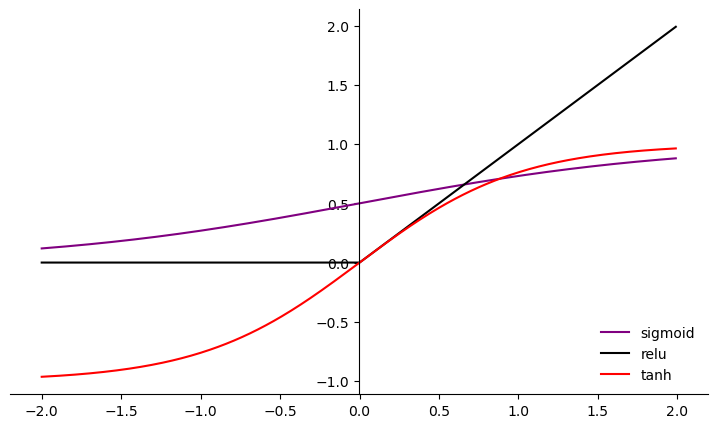

In [2]:
import matplotlib.pyplot as plt

xx=np.arange(-2,2,0.01)

fig, ax = plt.subplots(figsize=(9, 5))
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.plot(xx,sigmoid(xx)[0], color="purple", label="sigmoid")
ax.plot(xx,relu(xx)[0], color="black", label="relu")
ax.plot(xx,tanh(xx)[0], color="red", label="tanh")
ax.legend(loc="lower right", frameon=False);

And the below plots their derivative functions.

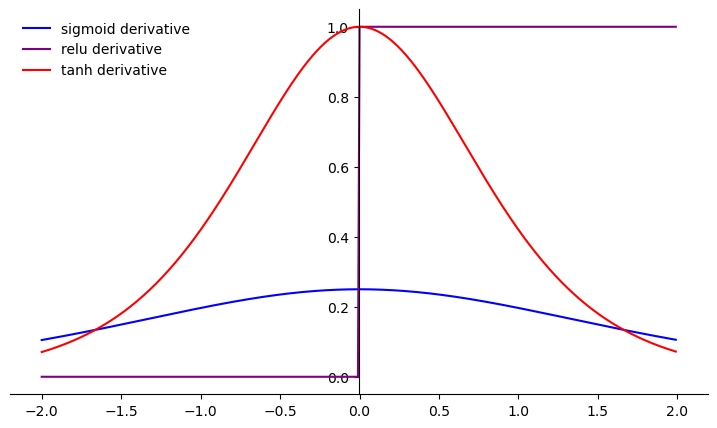

In [3]:
xx=np.arange(-2,2,0.01)

fig, ax = plt.subplots(figsize=(9, 5))
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.plot(xx,sigmoid(xx)[1], color="blue", label="sigmoid derivative")
ax.plot(xx,relu(xx)[1], color="purple", label="relu derivative")
ax.plot(xx,tanh(xx)[1], color="red", label="tanh derivative")
ax.legend(loc="upper left", frameon=False);

# Softmax Function

<p>Softmax units are often used in the output layer to determine predictions for categorical variables, as the function represents a probability distribution over a discrete variable with $k$ possible values.</p>

<p>$S(z)_i = \frac{e^{z_i}}{\sum_{j=1}^k e^z_j}, for ~i = 1, \ldots, k ~and ~z = (z_1, \ldots, z_k)$</p>

In [ ]:
class DenseLayer:

    # ...
    
    def softmax(self, inputs):
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    # ...

<p>Gradient of Softmax Function: $p_k - 1(y_i=k)$</p>

In [ ]:
class Network:
    
    # ...
    
    def _backprop(self, predicted, actual):
        # ...
        num_samples = len(actual)
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        # ...

    # ...

# Forward Propagation

<p>Training the network involves a forward propagation of the activation function, based on current weights and biases, and then a backpropagation of error in order to adjust the weights and biases. The first act of forward propagation is to multiply the values of neurons in the first layer by their corresponding weights (which are initialized randomly) and add the biases, producing $z$ values. An activation function $a(z)$ performed by each neuron then transforms the weighted sum, in a usually nonlinear fashion. The results of the activation functions of the first layer become the input values to subsequent layers.</p>

<p>$a^{(l)} = \sigma(w^{(l)} a^{(l-1)} + b^{(l)})$</p>

<p>We use matrix multiplication to compute the activations of all the neurons in the next layer simultaneously. Organize all activations from the first layer into a column vector. Organize all the weights as a matrix, where each row corresponds to all connections between neurons in the first layer and a particular neuron in the next layer. The superscripts in the below correspond to layer number and the subscripts correspond to a unit in the layer. It's accurate to think of each neuron as a function; it takes in the activations of all neurons in the previous layer, and outputs a number.</p>

$a^{(1)} = \sigma \left( \begin{bmatrix} w_{0,0} & w_{0,1} & \ldots & w_{0,n} \\ w_{1,0} & w_{1,1} & \ldots & w_{1,n} \\ \vdots & \dots & \ddots & \vdots \\ w_{k,0} & w_{k,1} & \ldots & w_{k,n} \\ \end{bmatrix} \begin{bmatrix} a_0^{(0)} \\ a_1^{(0)} \\ \vdots \\ a_n^{(0)} \end{bmatrix} + \begin{bmatrix} b_0 \\ b_1 \\ \ldots \\ b_n \\ \end{bmatrix} \right)$

In [ ]:
class DenseLayer

    # ...
    
    def forward(self, inputs, weights, bias, activation):

        Z_curr = np.dot(inputs, weights.T) + bias
        if activation == 'relu':
            A_curr = relu(inputs=Z_curr)
            
        elif activation == 'softmax':
            A_curr = softmax(inputs=Z_curr)
            
        return A_curr, Z_curr
    
    # ...

# Cost Functions

<p>We would like to know how well the network predicts the target variable $y$ from the inputs $x$, so that we can determine how much to adjust the weights and biases in the network. For this we will need a cost function, a.k.a. loss function.</p>

<img src="img/nn2-4.png" style="height: 400px; width:auto;">

<p>source: <a href="https://www.3blue1brown.com/lessons/backpropagation-calculus">Backpropagation Calculus, 3Blue1Brown</a></p>

<p>For a regression task, it's common to use a metric like MSE, and for multiclass classification tasks, it is common to use categorical cross-entropy.</p>

<h4>MSE:</h4>
<p>$C(w,b) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$</p>

<h4>Categorical Cross-Entropy:</h4>
<p>$C(w,b) = - \frac{1}{m} \sum_{i=1}^m y_i \cdot log(\hat{y}_i)$</p>

<p>The cross-entropy formula implies that the category labels are one-hot encoded, but this isn't actually necessary. Aside from the correct class, all predictions get multiplied by zero, therefore the calculation is equivalent to simply taking the negative log of the probability at the corresponding index for the correct class.</p>

In [ ]:
class Network:

    # ...
    
    def _calculate_loss(self, predicted, actual):
        samples = len(actual)

        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss
    
    # ...

# Backpropagation

The training process employs the gradient descent and backpropagation algorithms in tandem. Each time the network is traversed in a forward direction, the error of the network can be calculated as the difference between the output and ground truth by means of a cost/loss function. Consider $C_0$ to be the error of the network on the first training example. Our goal is to understand how sensitive the cost $C_0$ is to changes in a given weight $w$. In doing so, we use the chain rule of calculus.

<h3>$\frac{\partial C_0}{\partial w^{(L)}} = \frac{\partial C_0}{\partial a^{(L)}}  \frac{\partial a^{(L)}}{\partial z^{(L)}}  \frac{\partial z^{(L)}}{\partial w^{(L)}}$</h3>

<p>For a bias term, replace $w^{(L)}$ with $b^{(L)}$:</p>

<h3>$\frac{\partial C_0}{\partial b^{(L)}} = \frac{\partial C_0}{\partial a^{(L)}}  \frac{\partial a^{(L)}}{\partial z^{(L)}}  \frac{\partial z^{(L)}}{\partial b^{(L)}}$</h3>

<p>By tracking the dependencies through the tree, and multiplying together a long series of partial derivatives, we can calculate the derivative of the cost function with respect to any weight or bias in the network. In multi-dimensional space, the gradient vector of partial derivatives represents the direction of steepest ascent. Gradient descent is used to update the weights, such that each step looks like $w_{new} = w_{old} - \eta \frac{\partial C}{\partial w} w$, where $\eta$ is the learning rate.</p>

<p>The backpropagation equations for multiple neurons at a time can be written in matrix form. We start by computing the gradient of our scores, a special case of $\partial \mathbf{Z}$.</p>

<h4>$\frac{\partial \mathbf{L}_i}{\partial \mathbf{Z_k}} = p_k - 1(y_i=k)$</h4>
    <ul>
        <li>$(y_i=k)$ is an indicator function, $1$ if true and $0$ if false.</li>
    </ul>

<p>At each layer, we perform computations similar to the forward pass, except that instead of doing the computations for only $Z$ and $A$, we have to execute a computation for each parameter.</p>


<h4>Gradient of Hidden Layer $Z^{(L)}$:</h4>
    <ul>
        <li>$\partial \mathbf{Z}^{(L)} = \text{ReLU Deriv} = \partial \mathbf{A} ~where ~z \gt 0, ~else ~0$</li>
    </ul>

<h4>Weight Gradient of Current Layer:</h4>
    <ul>
        <li>$\partial \mathbf{W}^{(L)} = \mathbf{A}^{(L-1)} \cdot \partial \mathbf{Z}^{(L)}$</li>
    </ul>

<h4>Bias Gradient of Current Layer:</h4>
    <ul>
        <li>$\partial \mathbf{b}^{(L)} = \sum_i^m \partial \mathbf{Z}^{(L)(i)}$</li>
    </ul>

<h4>Activation Gradient:</h4>
    <ul>
        <li>$\partial \mathbf{A}^{(L)} = \partial \mathbf{Z}^{(L)} \cdot \mathbf{W}^{(L)}$</li>
    </ul>

In [ ]:
class DenseLayer:
    
    # ...
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(dA_curr, W_curr) 
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W_curr)
            
        return dA, dW, db
    
    # ...
    

class Network:
    
    # ..
    
    def _backprop(self, predicted, actual):
    num_samples = len(actual)

    ## compute the gradient on predictions
    dscores = predicted
    dscores[range(num_samples),actual] -= 1
    dscores /= num_samples

    dA_prev = dscores

    for idx, layer in reversed(list(enumerate(self.network))):
        dA_curr = dA_prev

        A_prev = self.memory[idx]['inputs']
        Z_curr = self.memory[idx]['Z']
        W_curr = self.params[idx]['W']

        activation = self.architecture[idx]['activation']

        dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

        self.gradients.append({'dW':dW_curr, 'db':db_curr})
        
    # ...

# Implementation

Putting it all together, and adding some functions to compile it all, we get the code written in the Joe Sasson Github repository.

In [22]:
import numpy as np, pandas as pd
from sklearn.preprocessing import LabelEncoder

class DenseLayer:
    def __init__(self, neurons):
        self.neurons = neurons
        
    def relu(self, inputs):
        return np.maximum(0, inputs)

    def softmax(self, inputs):
        exp_scores = np.exp(inputs)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs
    
    def relu_derivative(self, dA, Z):
        dZ = np.array(dA, copy = True)
        dZ[Z <= 0] = 0
        return dZ
    
    def forward(self, inputs, weights, bias, activation):
        Z_curr = np.dot(inputs, weights.T) + bias
        
        if activation == 'relu':
            A_curr = self.relu(inputs=Z_curr)
        elif activation == 'softmax':
            A_curr = self.softmax(inputs=Z_curr)
            
        return A_curr, Z_curr
    
    def backward(self, dA_curr, W_curr, Z_curr, A_prev, activation):
        if activation == 'softmax':
            dW = np.dot(A_prev.T, dA_curr)
            db = np.sum(dA_curr, axis=0, keepdims=True)
            dA = np.dot(dA_curr, W_curr) 
        else:
            dZ = self.relu_derivative(dA_curr, Z_curr)
            dW = np.dot(A_prev.T, dZ)
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = np.dot(dZ, W_curr)
            
        return dA, dW, db

class Network:
    def __init__(self):
        self.network = [] ## layers
        self.architecture = [] ## mapping input neurons --> output neurons
        self.params = [] ## W, b
        self.memory = [] ## Z, A
        self.gradients = [] ## dW, db
        
    def add(self, layer):
        self.network.append(layer)
            
    def _compile(self, data):
        for idx, layer in enumerate(self.network):
            if idx == 0:
                self.architecture.append({'input_dim':data.shape[1], 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            elif idx > 0 and idx < len(self.network)-1:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'relu'})
            else:
                self.architecture.append({'input_dim':self.network[idx-1].neurons, 'output_dim':self.network[idx].neurons,
                                         'activation':'softmax'})
        return self
    
    def _init_weights(self, data):
        self._compile(data)
        
        np.random.seed(99)
        
        for i in range(len(self.architecture)):
            self.params.append({
                'W':np.random.uniform(low=-1, high=1, 
                  size=(self.architecture[i]['output_dim'], 
                        self.architecture[i]['input_dim'])),
                'b':np.zeros((1, self.architecture[i]['output_dim']))})
        
        return self
    
    def _forwardprop(self, data):
        A_curr = data
        
        for i in range(len(self.params)):
            A_prev = A_curr
            A_curr, Z_curr = self.network[i].forward(inputs=A_prev, weights=self.params[i]['W'], 
                                           bias=self.params[i]['b'], activation=self.architecture[i]['activation'])
            
            self.memory.append({'inputs':A_prev, 'Z':Z_curr})
            
        return A_curr
    
    def _backprop(self, predicted, actual):
        num_samples = len(actual)
        
        ## compute the gradient on predictions
        dscores = predicted
        dscores[range(num_samples),actual] -= 1
        dscores /= num_samples
        
        dA_prev = dscores
        
        for idx, layer in reversed(list(enumerate(self.network))):
            dA_curr = dA_prev
            
            A_prev = self.memory[idx]['inputs']
            Z_curr = self.memory[idx]['Z']
            W_curr = self.params[idx]['W']
            
            activation = self.architecture[idx]['activation']

            dA_prev, dW_curr, db_curr = layer.backward(dA_curr, W_curr, Z_curr, A_prev, activation)

            self.gradients.append({'dW':dW_curr, 'db':db_curr})
            
    def _update(self, lr=0.01):
        for idx, layer in enumerate(self.network):
            self.params[idx]['W'] -= lr * list(reversed(self.gradients))[idx]['dW'].T  
            self.params[idx]['b'] -= lr * list(reversed(self.gradients))[idx]['db']
    
    def _get_accuracy(self, predicted, actual):
        return np.mean(np.argmax(predicted, axis=1)==actual)
    
    def _calculate_loss(self, predicted, actual):
        samples = len(actual)
        
        correct_logprobs = -np.log(predicted[range(samples),actual])
        data_loss = np.sum(correct_logprobs)/samples

        return data_loss
    
    def train(self, X_train, y_train, epochs):
        self.loss = []
        self.accuracy = []
        
        self._init_weights(X_train)      
        
        for i in range(epochs):
            yhat = self._forwardprop(X_train)
            self.accuracy.append(self._get_accuracy(predicted=yhat, actual=y_train))
            self.loss.append(self._calculate_loss(predicted=yhat, actual=y_train))
            
            self._backprop(predicted=yhat, actual=y_train)
            
            self._update()
            
            if i % 20 == 0:
                s = 'EPOCH: {}, ACCURACY: {}, LOSS: {}'.format(i, self.accuracy[-1], self.loss[-1])
                print(s)
                
        return self.accuracy
    # ...

I've left out the very bottom part, because we will adapt the code to use the MNIST dataset instead.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3, shuffle=True, random_state=123)

In [34]:
import warnings
warnings.filterwarnings('ignore')

model = Network()
model.add(DenseLayer(100))
model.add(DenseLayer(10))

accuracies = model.train(X_train=X_train, y_train=y_train, epochs=400)

EPOCH: 0, ACCURACY: 0.09466984884645982, LOSS: inf
EPOCH: 20, ACCURACY: 0.7748607796340493, LOSS: 7.5487881564175705
EPOCH: 40, ACCURACY: 0.8655529037390612, LOSS: 3.987766566561982
EPOCH: 60, ACCURACY: 0.8933969769291965, LOSS: 2.75027984290102
EPOCH: 80, ACCURACY: 0.9101034208432777, LOSS: 2.1069982745226534
EPOCH: 100, ACCURACY: 0.918854415274463, LOSS: 1.6116665887734334
EPOCH: 120, ACCURACY: 0.9347653142402546, LOSS: 1.3154260611870798
EPOCH: 140, ACCURACY: 0.9474940334128878, LOSS: 1.0729327555087163
EPOCH: 160, ACCURACY: 0.9530628480509149, LOSS: 0.9153682333050432
EPOCH: 180, ACCURACY: 0.960222752585521, LOSS: 0.762635840909532
EPOCH: 200, ACCURACY: 0.9618138424821002, LOSS: 0.7133932829753659
EPOCH: 220, ACCURACY: 0.9657915672235481, LOSS: 0.596829136145212
EPOCH: 240, ACCURACY: 0.9713603818615751, LOSS: 0.5372083781968721
EPOCH: 260, ACCURACY: 0.9729514717581543, LOSS: 0.476331886251159
EPOCH: 280, ACCURACY: 0.9761336515513126, LOSS: 0.41741243097266645
EPOCH: 300, ACCURACY: 

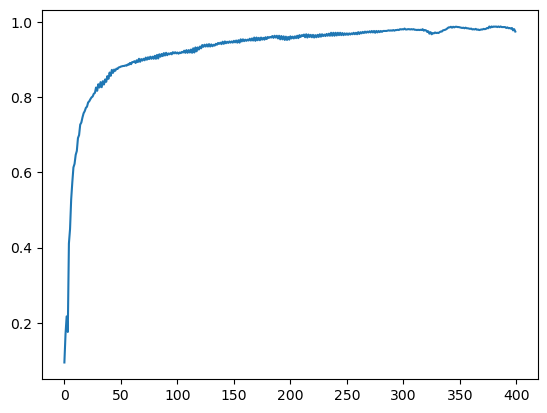

In [35]:
import matplotlib.pyplot as plt
plt.plot(accuracies);

# Prediction

We can make a prediction using the <code>_forwardprop</code> method, and see that it is an array of 10 probabilities defined by the softmax function.

In [39]:
yhat = model._forwardprop(X_test)
yhat[0]

array([4.14851746e-84, 1.38731086e-56, 1.86063556e-47, 1.00000000e+00,
       2.02691007e-77, 7.75062596e-33, 1.07656059e-97, 3.45695153e-63,
       1.00394776e-37, 6.25668614e-19])

A bar plot makes it easy to read which value represents the argmax.

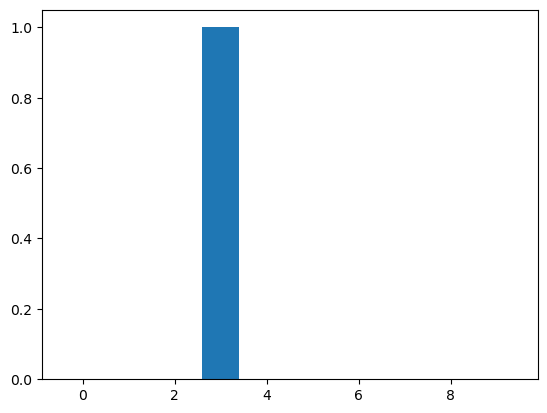

In [42]:
plt.bar(range(0,10),yhat[0]);

When we compare to the ground truth for that instance, we see the prediction is correct.

In [43]:
y_test[0]

3

And to further confirm, we can display the image of the test instance predicted upon.

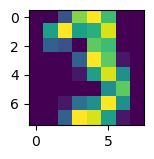

In [79]:
plt.figure(figsize = (1.5,1.5))
plt.imshow(np.reshape(X_test[0], (8,8)));

# What's Next?

<p>In the next article, we return to the Keras library, and explore the long list of tunable parameters and hyperparameters that can help optimize the performance of the network.</p>

# References

- Sasson, J. (2022). Coding A Neural Network From Scratch in NumPy. Towards Data Science. https://towardsdatascience.com/coding-a-neural-network-from-scratch-in-numpy-31f04e4d605

- Brownlee, J. (2021). Better Deep Learning (1st ed.). Machine Learning Mastery. https://machinelearningmastery.com/better-deep-learning/

- Brownlee, J. (2021). Optimization for Machine Learning (A. Tam, Ed.) (1st ed.). MachineLearningMastery. https://machinelearningmastery.com/optimization-for-machine-learning/

- Nielsen, M. (2018). Neural Networks and Deep Learning. http://neuralnetworksanddeeplearning.com/index.html

- Sanderson, G. (2017). Neural Networks. 3Blue1Brown. https://www.3blue1brown.com/topics/neural-networks

- Ian Goodfellow, Yoshua Bengio, and Aaron Courville. Deep Learning. MIT Press, 2016.
https://www.deeplearningbook.org/

- Cohen, M. X. (2024). A deep understanding of deep learning [Online Video]. Udemy. https://www.udemy.com/course/deeplearning_x